<a href="https://colab.research.google.com/github/hesolar/TrabajoDistribuidos2020solar-escudero/blob/master/embedding_search_engine_usingVPTREES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Pasos Previos

Descargamos la lógica necesaria para montar el motor de búsqueda por embeddings

In [123]:
!wget https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/image-hashing-search-engine/hashing-search-engine.zip
!unzip -qq hashing-search-engine.zip
%cd hashing-search-engine

!pip install opencv-contrib-python
!pip install vptree

# Resto de paquetes que utilizaremos en las practicas
from imutils import paths
import argparse
import pandas as pd
import time
import sys
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
import vptree




--2021-05-31 12:40:42--  https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/image-hashing-search-engine/hashing-search-engine.zip
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.235.0
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.235.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113505 (111K) [application/zip]
Saving to: ‘hashing-search-engine.zip’

hashing-search-engi 100%[===================>] 110.84K   457KB/s    in 0.2s    

2021-05-31 12:40:43 (457 KB/s) - ‘hashing-search-engine.zip’ saved [113505/113505]

/content/hashing-search-engine/hashing-search-engine/hashing-search-engine/hashing-search-engine


Descargamos los modelos para la detección de caras, que utilizamos en el cuaderno anterior

In [124]:
!wget https://www.dropbox.com/s/uji1ufb009ic3m0/mobilenet_graph.pb?dl=0 -O mobilenet_graph.pb
# Leer mobilenet_graph.pb
with tf.io.gfile.GFile('mobilenet_graph.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

--2021-05-31 12:40:49--  https://www.dropbox.com/s/uji1ufb009ic3m0/mobilenet_graph.pb?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/uji1ufb009ic3m0/mobilenet_graph.pb [following]
--2021-05-31 12:40:49--  https://www.dropbox.com/s/raw/uji1ufb009ic3m0/mobilenet_graph.pb
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf61b229c8e33eac39d0c7f6db5.dl.dropboxusercontent.com/cd/0/inline/BPhdi6GdqmwlCADZst3t5Zd9t33RcFURPbz9DaxkJTilZgp-sTBm6v92qMDQfAea8sNUi7SQ0X1lD9HR9D4IjUtfbcI6-iukztF1Uvl0mAMuu_cFe6p6qU8hP21r7y6m2CjpIiX9bfD3sy14U8DCtjQ1/file# [following]
--2021-05-31 12:40:49--  https://ucf61b229c8e33eac39d0c7f6db5.dl.dropboxusercontent.com/cd/0/inline/BPhdi6GdqmwlCADZst3t5Zd9t33RcFURPbz9DaxkJTilZgp-sTBm6v92qMDQfAea8sN

Finalmente descargamos el dataset

In [125]:
!wget https://www.dropbox.com/s/chfwr4x475y3p1v/noticiasFotos.zip?dl=0 -O 2.zip
!unzip 2.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: 2/467124.jpg            
  inflating: 2/467130.jpg            
  inflating: 2/467131.jpg            
  inflating: 2/467132.jpg            
  inflating: 2/467135.jpg            
  inflating: 2/467136.jpg            
  inflating: 2/467138.jpg            
  inflating: 2/467139.jpg            
  inflating: 2/467140.jpg            
  inflating: 2/46715.jpg             
  inflating: 2/467156.jpg            
  inflating: 2/46716.jpg             
  inflating: 2/467161.jpg            
  inflating: 2/467163.jpg            
  inflating: 2/467164.jpg            
  inflating: 2/467169.jpg            
  inflating: 2/46717.jpg             
  inflating: 2/467170.jpg            
  inflating: 2/467173.jpg            
  inflating: 2/453565.jpg            
  inflating: 2/453569.jpg            
  inflating: 2/45357.jpg             
  inflating: 2/453572.jpg            
  inflating: 2/453576.jpg            
  inflating: 2/453577.jpg  

Bajamos los embeddings

In [126]:
!wget https://www.dropbox.com/s/lw24ve7ndobd4y5/EmbeddingsFotos.csv?dl=0 -O EmbeddingsFotos.csv
df = pd.read_csv('EmbeddingsFotos.csv')

--2021-05-31 12:41:38--  https://www.dropbox.com/s/lw24ve7ndobd4y5/EmbeddingsFotos.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/lw24ve7ndobd4y5/EmbeddingsFotos.csv [following]
--2021-05-31 12:41:38--  https://www.dropbox.com/s/raw/lw24ve7ndobd4y5/EmbeddingsFotos.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8d5d847ac0dce48a80b3cbd9a3.dl.dropboxusercontent.com/cd/0/inline/BPigTKJzf5g0o1-cwzoBraxzhFkIHGElctR2eschUoqltel8uYXVerb90Wy30jDYKfKfLscaEfaBGXa5E2gfT3coL6mnuSR3q4SUhyBhk_-_Huri8WmZ4nn7vMIRdyoSWMVP52bX10lFCuci1HoI2ylo/file# [following]
--2021-05-31 12:41:38--  https://uc8d5d847ac0dce48a80b3cbd9a3.dl.dropboxusercontent.com/cd/0/inline/BPigTKJzf5g0o1-cwzoBraxzhFkIHGElctR2eschUoqltel8uYXVerb90Wy30jDY

# 2. Creación del dataset de búsqueda de caras para vptrees

Esta función está explicada en la anterior sección , obtiene de una imagen un vector(bboxes) que tiene todas las caras que se han podido detectar en la imagen

In [127]:
def detect_faces(image, score_threshold=0.7):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    
    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')
    
    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes



Esta función una vez obtenidas las caras las recorta

In [128]:
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

Esta función utilizando la librería de tratamiento de imagen cv2 lee una imagen desde un directorio, es útil ya que nos permite leer el color en RGB , la segunda función nos muestra una figura de una imagen


In [129]:
from google.colab.patches import cv2_imshow
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{name}'), cv2.COLOR_BGR2RGB)

def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

Utilizaremos el fichero de embeddings para tratar de buscar aquellos similares

Una vez que ya disponemos de las imágenes de las caras utilizaremos las búsquedas con vptrees.

# 3 VPTrees y Hashing para la búsqueda de imágenes

La idea central de este notebook consiste en establecer una función embedding que marque de manera única a cada imagen , en función de la "proximidad" de estos embeddings generados a partir de las imágenes podremos encontrar aquellas imágenes con un hash similar.
Las imágenes que vamos a comparar son las caras extraidas de nuestras imágenes.

### Ahora implementaremos nuestro índice con los embeddings



In [177]:
args = {
    "images": "3",  #input de imágenes de caras en las que buscaremos coincidencias
    "tree": "vptree.pickle",
    "hashes": "hashes.pickle"
}

In [178]:
df = pd.read_csv('EmbeddingsFotos.csv')
df.head()
!wget https://www.dropbox.com/s/z0o1of3580smtwr/facenet_keras.h5?dl=0 -O facenet_keras.h5
facenet = load_model('facenet_keras.h5')

--2021-05-31 13:31:31--  https://www.dropbox.com/s/z0o1of3580smtwr/facenet_keras.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/z0o1of3580smtwr/facenet_keras.h5 [following]
--2021-05-31 13:31:31--  https://www.dropbox.com/s/raw/z0o1of3580smtwr/facenet_keras.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc388eb4de17557609237f4ca1d8.dl.dropboxusercontent.com/cd/0/inline/BPhIupsEoSjHnwRvj_OUcDTVti6BxknX-TX87FQVGZ8LsU50JuEB3MDtuug4DbG0CDbjWcljE-Gm6vgFnmWuf3EyJz6nprRrQhgLFijZSIcC1FHlDjxSmtz36oR7IBeecpbyWuI4waML2CHXuuMm-6WO/file# [following]
--2021-05-31 13:31:32--  https://uc388eb4de17557609237f4ca1d8.dl.dropboxusercontent.com/cd/0/inline/BPhIupsEoSjHnwRvj_OUcDTVti6BxknX-TX87FQVGZ8LsU50JuEB3MDtuug4DbG0CDbjWcljE

In [139]:
known_embeddings = []

print('Procesando rostros conocidos...')
for name in os.listdir('/content/hashing-search-engine/queries/'):
    if name.endswith('.jpg'):
        # print(f'   {name}')
        image = load_image('/content/hashing-search-engine/queries/',name)
        bboxes = detect_faces(image)
        if len(bboxes)>0:
          print(name)
          face = extract_faces(image,bboxes)
          for f in faces:
            known_embeddings.append(compute_embedding(facenet,f))

Procesando rostros conocidos...
prueba.jpg


In [140]:
embeddingsModelo = df['Embedding']
nombreFoto = df['NombreFoto']
print(nombreFoto[0:5])
print(embeddingsModelo[0:5])

0    462220.jpg 0
1    462220.jpg 1
2     44569.jpg 0
3     44569.jpg 1
4     44569.jpg 2
Name: NombreFoto, dtype: object
0    [[ 2.3611324   0.7700528   1.5315906  -1.38208...
1    [[-0.18996963  0.47556552  0.3286136   1.53095...
2    [[-0.67055297 -0.4772751  -0.05659456  0.97165...
3    [[-8.7787104e-01  1.4074993e+00 -9.2881995e-01...
4    [[ 0.55190855  0.47906682 -1.9257076  -0.58596...
Name: Embedding, dtype: object


In [205]:
listaEmbedings=[]
for caraEmb in embeddingsModelo:  
  lista=caraEmb.replace('[','').replace(']','').split(' ')
  aux=[]
  for elem in lista:
    if elem != '':
      aux.append(float(elem))
  aux2=[]
  aux2.append(aux) 
     
  listaEmbedings.append(np.array(aux2, dtype='f')[0])

In [192]:
def compare_faces(embs_ref, emb_desc, umbral=10):
    distancias = []
    for emb_ref in embs_ref:
        distancias.append(np.linalg.norm(emb_ref-emb_desc))
    distancias = np.array(distancias)
    return distancias, list(distancias<=umbral)

In [217]:
# Cons
print("Construcción del vptrees con el dccionario de hashing")
# points = list(hashes.keys())
points= listaEmbedings
# for p in points:
#   print(p)
#   print('heello')
tree = vptree.VPTree(points, compare_faces2)

Construcción del vptrees con el dccionario de hashing


In [218]:
def compare_faces2(a, b, umbral=10):
    return np.linalg.norm(a-b)


In [222]:
ls

2/     EmbeddingsFotos.csv  index_images.py     pyimagesearch/  vptree.pickle
2.zip  facenet_keras.h5     mobilenet_graph.pb  queries/
3/     hashes.pickle        prueba.jpg          search.py


In [243]:
#Comprueba si dos embeddings son iguales
def emb_iguales(lista1,lista2):
  for indice, (item1, item2) in enumerate(zip(lista1, lista2)):
    if item1 != item2:
      return False
  return True
#mostrar imagen
def mostrarImagen(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.imshow(img2)
        plt.show()
        plt.figure()

# **4.Busqueda de una cara** , nota por simplicidad utilizaremos fotos con una sola cara .

In [145]:
!wget https://www.dropbox.com/s/jc493jeqq2wshuy/conchi.jpg?dl=0 -O prueba.jpg

--2021-05-31 12:41:51--  https://www.dropbox.com/s/jc493jeqq2wshuy/conchi.jpg?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jc493jeqq2wshuy/conchi.jpg [following]
--2021-05-31 12:41:51--  https://www.dropbox.com/s/raw/jc493jeqq2wshuy/conchi.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5b1836e4677e5c394bda942e2.dl.dropboxusercontent.com/cd/0/inline/BPiVbPEpeSq5M6x6ErdDZ9VMv10Z34cINYOYqVBhLD4DiiN6mxSvbbwNLeBHWQnWA4EP-CdkxNSiRIUYcWLDlHsFvGUveMDaR1k3B-b6dIOFAYsvnfVxoGS4c2aaWsBMqoWMnBERi0w10vjcFeb4Z7xm/file# [following]
--2021-05-31 12:41:51--  https://uce5b1836e4677e5c394bda942e2.dl.dropboxusercontent.com/cd/0/inline/BPiVbPEpeSq5M6x6ErdDZ9VMv10Z34cINYOYqVBhLD4DiiN6mxSvbbwNLeBHWQnWA4EP-CdkxNSiRIUYcWLDlHsFvGU

In [146]:
ls

2/     EmbeddingsFotos.csv  index_images.py     pyimagesearch/  vptree.pickle
2.zip  facenet_keras.h5     mobilenet_graph.pb  queries/
3/     hashes.pickle        prueba.jpg          search.py


Embedding:
[0.46163118, 1.2827555, 2.0616877, -0.6365244, 0.545948, -0.1488898, -0.043988742, 0.60198027, 0.22426867, -0.8810258, -0.034480464, 0.42573512, 1.2733778, 1.3547221, -0.462155, -1.6712674, 0.39588773, -0.7784619, 0.87781775, -0.17642128, -1.4390091, 0.16761951, -0.70601463, 0.8348232, -0.50916636, -0.13232526, -0.300391, 1.0891649, 0.9098565, 0.2001862, -1.1476884, -0.8619923, 0.9173147, -0.76932603, -0.6081056, 0.86677134, 0.20640522, -0.064809956, -1.3798726, 1.4493724, 1.7715548, 0.52616966, -0.33045226, 0.85914445, -2.2566316, 0.35756692, -1.1939142, -0.38833457, 0.36375785, -0.32485488, 2.2755663, 2.0086493, 0.65205735, -3.3605607, -0.3839988, 1.9588538, 0.581668, -0.30730498, 0.65510637, -0.40517816, 0.60412306, -1.2922708, 0.98231685, 1.7684314, -0.8914479, 0.009155557, -0.11812661, -0.28792945, 2.0911756, -0.47873768, 0.4845362, -0.84723794, 0.6003987, -0.5795398, 1.3744156, 0.7521509, 0.8756281, 0.84155405, -2.0076556, -0.103510335, -0.37200466, 1.8756262, 0.173786

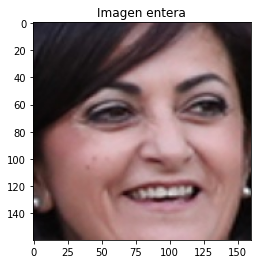

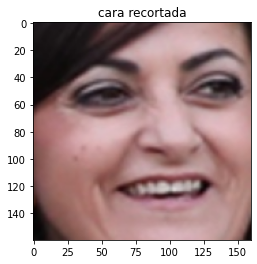

In [223]:
#1.leemos la foto y extraemos la cara
img=cv2.cvtColor(cv2.imread('/content/hashing-search-engine/queries/prueba.jpg'), cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(img)
plt.title('Imagen entera')

#2 Detectamos la cara y la extraemos
bboxes=detect_faces(img)
cara= extract_faces(img,bboxes)
plt.figure()
plt.title('cara recortada')
plt.imshow(cara[0])

cv2.imwrite('queries/prueba.jpg', cv2.cvtColor(cara[0], cv2.COLOR_RGB2BGR))    

target=compute_embedding(facenet,cara[0])
target=list(target[0])
print('Embedding:')
print(target)

Ahora buscaremos utilizando nuestro árbol todas las imágenes que se encuentran a < 10

473680.jpg


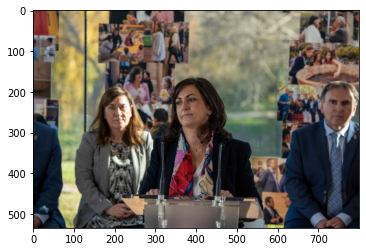

188.jpg


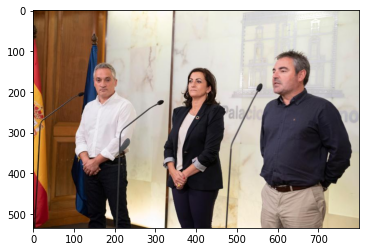

473943.jpg


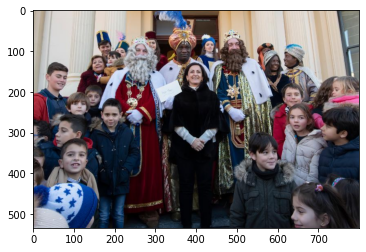

1126.jpg


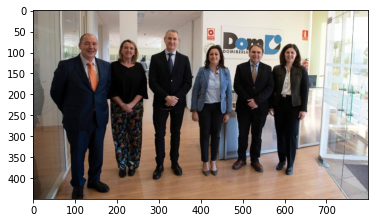

473892.jpg


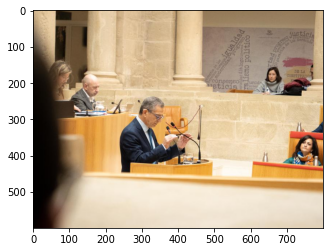

1303.jpg


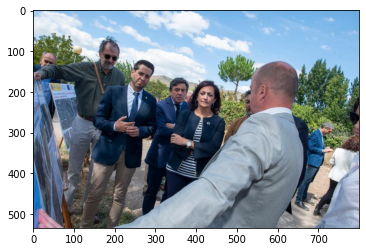

28196.jpg


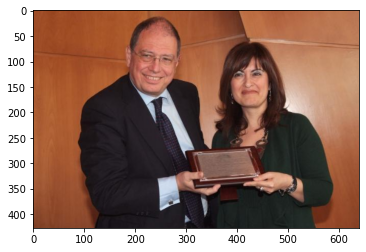

472503.jpg


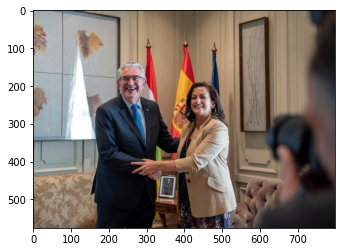

469419.jpg


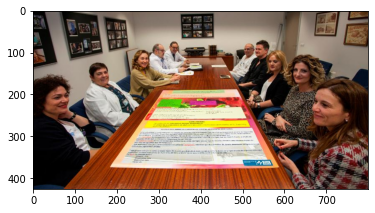

439038.jpg


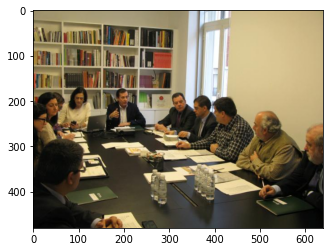

10290


<Figure size 432x288 with 0 Axes>

In [284]:
emb=tree.get_n_nearest_neighbors(target, 10)
for el in emb:

  emb=el[1]
  cont=0
  listAux=[]
  for caraEmb in embeddingsModelo:  
    lista=caraEmb.replace('[','').replace(']','').split(' ')
    aux=[]
    for elem in lista:
      if elem != '':
        aux.append(float(elem))
    aux2=[]
    aux2.append(aux)    
    fin=[np.array(aux2, dtype='f')]

    if emb_iguales(emb,fin[0][0]):

    
      nomF=nombreFoto[cont].split(' ')[0]
      #if not nomF in listAux:
      # listAux.append(nomF)
        #image = load_image('2', nomF)
        #mostrarImagen(image)
      print(nomF)
      image = cv2.imread("2/"+nomF)
      mostrarImagen(image)

    cont=cont+1;
    

print(cont)
  

En este otro ejemplo sacaremos la imágen que más se parece en el dataset

473680.jpg


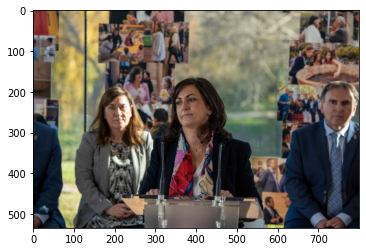

10290


<Figure size 432x288 with 0 Axes>

In [301]:
distancia,emb=tree.get_nearest_neighbor(target)
# # Query n-points.
# emb=tree.get_n_nearest_neighbors(target, 10)

  # emb=el[1]
cont=0
listAux=[]
for caraEmb in embeddingsModelo:  
  lista=caraEmb.replace('[','').replace(']','').split(' ')
  aux=[]
  for elem in lista:
    if elem != '':
      aux.append(float(elem))
  aux2=[]
  aux2.append(aux)    
  fin=[np.array(aux2, dtype='f')]

  if emb_iguales(emb,fin[0][0]):

  
    nomF=nombreFoto[cont].split(' ')[0]
    #if not nomF in listAux:
    # listAux.append(nomF)
      #image = load_image('2', nomF)
      #mostrarImagen(image)
    print(nomF)
    image = cv2.imread("2/"+nomF)
    mostrarImagen(image)

  cont=cont+1;
  

print(cont)
  
